In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import string
import random
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
from sklearn.feature_extraction.text import CountVectorizer
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat
import warnings
import nltk
warnings.filterwarnings('ignore')

%matplotlib inline

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [32]:
data = pd.read_csv('text_data.csv')

In [35]:
data.head()

,Student Response Type,Level (Unit),Outcome,Action,Input,Total Num Hints,KC (Default)
0,ATTEMPT,IWT_S09explainTutorA-A,INCORRECT,UpdateComboBox,a,NaN,s12
1,ATTEMPT,IWT_S09explainTutorA-A,CORRECT,UpdateComboBox,a,NaN,s3
2,ATTEMPT,IWT_S09explainTutorA-A,INCORRECT,UpdateComboBox,the,NaN,s1
3,ATTEMPT,IWT_S09explainTutorA-A,INCORRECT,UpdateComboBox,no article,NaN,s8
4,ATTEMPT,IWT_S09explainTutorA-A,INCORRECT,UpdateComboBox,no article,NaN,s11


In [6]:
data['Student Response Type'].value_counts()

ATTEMPT         21519
HINT_REQUEST      880
Name: Student Response Type, dtype: int64

In [10]:
data['Level (Unit)'].value_counts()

IWT_S09explainTutorA-B    3209
IWT_S09articleTutorA-A    3024
IWT_S09explainTutorB-A    2966
IWT_S09articleTutorB-B    2936
IWT_S09explainTutorB-B    2718
IWT_S09explainTutorA-A    2599
IWT_S09articleTutorA-B    2476
IWT_S09articleTutorB-A    2471
Name: Level (Unit), dtype: int64

In [11]:
data['Outcome'].value_counts()

CORRECT          13376
INCORRECT         7974
HINT               709
HINT_NEXT          156
HINT_PREVIOUS       15
Name: Outcome, dtype: int64

In [13]:
data['Action'].value_counts()

UpdateComboBox     19281
ButtonPressed       2170
UpdateTextArea       605
UpdateTextField      343
Name: Action, dtype: int64

In [18]:
data['Problem View'].value_counts()

1    21771
2      538
3       64
4       12
6       11
5        3
Name: Problem View, dtype: int64

In [19]:
data['Total Num Hints'].value_counts()

3.0    331
2.0    322
4.0    212
1.0     10
Name: Total Num Hints, dtype: int64

In [57]:
data['KC (Default)'].value_counts()

s3         2313
s1         2249
s2         2120
unnamed    2103
s4         1792
s11        1550
s8         1408
s12        1394
s7         1387
s6         1367
s9         1353
s10        1207
s5         1152
done        535
e9          290
Name: KC (Default), dtype: int64

# LDA - Topic Modelling

### Scenario

Imagine a scenario where a varsity sales associate and prospective client are having a conversation. They talk for a few minutes and the sales associate feels this lead is not going to convert to a customer. Now, what can we do that can help the sales associate close this call. 

We could provide information that she/he can use in the conversation that gives a better understanding of the prospective customer. 

We can give information at two points during the call.
1. At the start of the call
2. During the conversation

Based on the vasts amounts of call data that varsity has, we can identify topics of concern for people in specific states, students in specific school/ state districts, both characteristic or behavior wise, academic or otherwise. 

For examples:-
Parents of students from California would have drastically different concerns compared to ones in Washington or Nebraska. Student in California might be participating in more after school music and sports class where students in Washington are more concerned to know about the experience of varsity instructors to Washington's education state board curriculum, whereas parents in Nebraska might be more concerned about pricing and frequency of classes. 

Knowing by collecting and processing this data through LDA and Cognitive Task Analysis(Explained later) could facilitate the follow intervention through a pop-up message during a call

<i>"Hey Kevin, this conversation seem similar to the one you had 2 days ago. (or similar to the one Cathy has a month ago)
Your clients main concerns seem to be 
1. Timing
2. Location 

Here is a summary of the call from our past records:-
Problem:- Timing/ Scheduling conflict due to after school sports and music class
Soultion :- Schedule Algebra tutor session during school lunch breaks.
Number of instructors comfortable with that timing: 12"
</i>

Possible solutions for Nebraskan pricing calls could be sign-on with spaced sessions (Make it twice a month instead of 4 times a month).

One of the advantages of this method and a problem it solves is that an LDA model can analyse all the sales conversations at better speed and efficiency than a sales associate.


In [40]:
# SpaCy Parser for questions
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


In [43]:
data['Input'] = data['Input'].astype(str)

In [68]:
tqdm.pandas()
general_text = data['Input'].progress_apply(spacy_tokenizer)


100%|██████████| 22399/22399 [00:03<00:00, 6558.75it/s]

### Count Vectorizer

In [69]:
vectorizer_general_text = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
general_text_vectorized = vectorizer_general_text.fit_transform(general_text)


### Applying LDA Model

In [70]:
# Latent Dirichlet Allocation Model
lda_general_text = LatentDirichletAllocation(n_components=20, max_iter=15, learning_method='online',verbose=True)
general_text_lda = lda_general_text.fit_transform(general_text_vectorized)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15


In [71]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

### Analysing All the Knowledge Components

In [72]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_general_text, general_text_vectorized, vectorizer_general_text, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6      193.514725   42.549332       1        1  26.106083
17       5.283508  420.309631       2        1  13.045527
14    -227.764053  -83.881454       3        1  10.856792
16    -210.302460  407.807190       4        1   9.478861
18    -339.310547  239.807297       5        1   7.473240
15     117.449562 -128.758087       6        1   6.521223
7       -6.002579   40.927406       7        1   4.902415
10    -191.671188   91.076103       8        1   4.687226
4       10.553909 -341.162354       9        1   2.089989
13     305.678528  223.323318      10        1   2.044479
9      212.403839  407.770630      11        1   1.931756
5      329.546234 -133.820297      12        1   1.458785
11     -61.192806 -142.710968      13        1   1.447225
0       97.398819  210.205795      14        1   1.353567
2      420.020111   53.494255      15        1   1.264587
1     -410.183868   41.288185      16        1   1.119444
3      221.426758 -314.344269      17        1   1.097519
12     -87.382942  235.519150      18        1   1.049905
19    -201.456558 -315.340546      19        1   1.038057
8     -397.787415 -190.303223      20        1   1.033319, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
9     Default  1361.000000        article  1361.000000  30.0000  30.0000
31    Default  3048.000000        general  3048.000000  29.0000  29.0000
66    Default  9691.000000           noun  9691.000000  28.0000  28.0000
62    Default   906.000000            nan   906.000000  27.0000  27.0000
72    Default  2805.000000         phrase  2805.000000  26.0000  26.0000
107   Default  1058.000000            use  1058.000000  25.0000  25.0000
56    Default   967.000000           mean   967.000000  24.0000  24.0000
112   Default  1340.000000           word  1340.000000  23.0000  23.0000
58    Default  1336.000000         modify  1336.000000  22.0000  22.0000
50    Default  1270.000000           like  1270.000000  21.0000  21.0000
4     Default  1246.000000      adjective  1246.000000  20.0000  20.0000
24    Default  1327.000000       definite  1327.000000  19.0000  19.0000
22    Default  2466.000000          count  2466.000000  18.0000  18.0000
48    Default   925.000000         letter   925.000000  17.0000  17.0000
68    Default   925.000000         number   925.000000  16.0000  16.0000
86    Default   924.000000         single   924.000000  15.0000  15.0000
65    Default   989.000000            non   989.000000  14.0000  14.0000
75    Default   706.000000  prepositional   706.000000  13.0000  13.0000
10    Default  1479.000000          begin  1479.000000  12.0000  12.0000
88    Default  1478.000000          sound  1478.000000  11.0000  11.0000
87    Default  1478.000000       singular  1478.000000  10.0000  10.0000
43    Default   826.000000           know   826.000000   9.0000   9.0000
73    Default   834.000000         plural   834.000000   8.0000   8.0000
57    Default   532.000000        mention   532.000000   7.0000   7.0000
67    Default   586.000000           numb   586.000000   6.0000   6.0000
71    Default   586.000000        ordinal   586.000000   5.0000   5.0000
78    Default   585.000000           rank   585.000000   4.0000   4.0000
16    Default   624.000000         clause   624.000000   3.0000   3.0000
115   Default   263.000000            yes   263.000000   2.0000   2.0000
20    Default   742.000000      consonant   742.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2     Topic20     0.623832       absolute    17.217600   1.2546  -6.7074
110   Topic20     0.623832           want    17.646017   1.2300  -6.7074
25    Topic20     0.623832           easy    18.122032   1.2034  -6.7074
111   Topic20     0.623832            way    18.13177

#### Explanation

The previous LDA graph does not give use much useful info based on the topics and associated words. By filtering our problem space, we could extract more context. 

We can implement an LDA to identify topics within self-reflection answers for:-
1. Knowledge Component 3 that are tagged incorrect. 
2. Knowledge Component 3 that are tagged correct. 

We can try infer the main topics/problems based on the words.

In [95]:
tqdm.pandas()
general_text = data['Input'][data['KC (Default)'] == 's3'][data['Outcome'] == 'INCORRECT'].progress_apply(spacy_tokenizer)

vectorizer_general_text = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
general_text_vectorized = vectorizer_general_text.fit_transform(general_text)

# Latent Dirichlet Allocation Model
lda_general_text = LatentDirichletAllocation(n_components=5, max_iter=15, learning_method='online',verbose=True)
general_text_lda = lda_general_text.fit_transform(general_text_vectorized)

pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_general_text, general_text_vectorized, vectorizer_general_text, mds='tsne')
dash


100%|██████████| 911/911 [00:00<00:00, 5729.91it/s]

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15
iteration: 15 of max_iter: 15


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2        2.856195  -66.625435       1        1  66.666173
1      126.249077  -68.950478       2        1  15.136526
4      123.919388 -192.341705       3        1  10.125096
0      128.564453   54.442116       4        1   4.328282
3      249.640060  -71.269867       5        1   3.743923, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
17    Default  413.000000           noun  413.000000  30.0000  30.0000
22    Default  173.000000         phrase  173.000000  29.0000  29.0000
11    Default   39.000000           know   39.000000  28.0000  28.0000
13    Default   66.000000           mean   66.000000  27.0000  27.0000
28    Default   66.000000            use   66.000000  26.0000  26.0000
0     Default   26.000000       --select   26.000000  25.0000  25.0000
20    Default   26.000000          one--   26.000000  24.0000  24.0000
2     Default   39.000000      adjective   39.000000  23.0000  23.0000
8     Default   36.000000       definite   36.000000  22.0000  22.0000
30    Default   36.000000           word   36.000000  21.0000  21.0000
15    Default   36.000000         modify   36.000000  20.0000  20.0000
5     Default   20.000000         clause   20.000000  19.0000  19.0000
7     Default  148.000000          count  148.000000  18.0000  18.0000
12    Default   24.000000           like   24.000000  17.0000  17.0000
4     Default  138.000000          begin  138.000000  16.0000  16.0000
27    Default  138.000000          sound  138.000000  15.0000  15.0000
26    Default  138.000000       singular  138.000000  14.0000  14.0000
24    Default   18.000000  prepositional   18.000000  13.0000  13.0000
3     Default  123.000000        article  123.000000  12.0000  12.0000
9     Default  117.000000        general  117.000000  11.0000  11.0000
1     Default   16.000000        -select   16.000000  10.0000  10.0000
19    Default   16.000000           one-   16.000000   9.0000   9.0000
29    Default   75.000000          vowel   75.000000   8.0000   8.0000
6     Default   65.000000      consonant   65.000000   7.0000   7.0000
10    Default   43.000000     indefinite   43.000000   6.0000   6.0000
25    Default   13.000000           rank   13.000000   5.0000   5.0000
18    Default   13.000000           numb   13.000000   4.0000   4.0000
21    Default   13.000000        ordinal   13.000000   3.0000   3.0000
16    Default   12.000000            non   12.000000   2.0000   2.0000
23    Default   12.000000         plural   12.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
20     Topic5   25.906612          one--   26.899171   3.2474  -1.1196
14     Topic5    0.949589        mention    9.538394   0.9780  -4.4259
23     Topic5    0.953163         plural   12.258031   0.7309  -4.4221
16     Topic5    0.951476            non   12.740595   0.6905  -4.4239
25     Topic5    0.948828           rank   13.326626   0.6427  -4.4267
18     Topic5    0.948732           numb   13.326511   0.6427  -4.4268
21     Topic5    0.948709        ordinal   13.326374   0.6426  -4.4268
19     Topic5    0.949034           one-   16.019664   0.4589  -4.4264
1      Topic5    0.948742        -select   16.019357   0.4586  -4.4268
24     Topic5    0.948594  prepositional   18.002187   0.3418  -4.4269
5      Topic5    0.948386         clause   20.871135   0.1937  -4.4271
12     Topic5    0.948392           like   24.711846   0.0248  -4.4271
30     Topic5    0.949082           word   36.147545  -0.3548  -4.4264
15     Topic5    0.949051         modify   36.147612  -0.3549  -4.4264
8      Topic5    0.948539       definite   36.932903  -0.3769  -4.4270
11     Topic5    0.948446           know   39.555882  -0.4456  -4.4271
2      Topic5    0.948648      adjective   39.802520  -0.4516  -4.4269
1

### Explanation
Once the LDA model is finely tuned to make sense, an expert, in this case an instructor would sit down and look at the topic,, the words associated and a few examples of topic 1 answer examples to assign a name to the topic

KC-3 is identifying grammatical structures from a given sentence. So the question has example text that asks the student to select the noun in the question. 

For Topic 1:- The problem here seems to be something to do with singular noun phrases. 
For Topic 2:- Word noun modifiers

We can infer here that over 80% of the problems seem to be due to difficulty in identifying singular noun phrases and differentiating between noun modifiers. 


In [84]:
tqdm.pandas()
general_text = data['Input'][data['KC (Default)'] == 's3'][data['Outcome'] == 'CORRECT'].progress_apply(spacy_tokenizer)

vectorizer_general_text = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
general_text_vectorized = vectorizer_general_text.fit_transform(general_text)

# Latent Dirichlet Allocation Model
lda_general_text = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online',verbose=True)
general_text_lda = lda_general_text.fit_transform(general_text_vectorized)

pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_general_text, general_text_vectorized, vectorizer_general_text, mds='tsne')
dash


100%|██████████| 1261/1261 [00:00<00:00, 7585.16it/s]

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      173.354721   61.398590       1        1  20.002530
1     -113.264542  237.554733       2        1  20.002462
4     -257.828156  -79.031326       3        1  19.999075
3      -43.562271 -337.121735       4        1  19.998975
0      294.059052 -252.597549       5        1  19.996958, topic_info=     Category        Freq    Term       Total  loglift  logprob
term                                                           
3     Default  638.000000  single  638.000000      4.0   4.0000
1     Default  638.000000    noun  638.000000      3.0   3.0000
2     Default  637.000000  number  637.000000      2.0   2.0000
0     Default  638.000000  letter  638.000000      1.0   1.0000
1      Topic1  127.616576    noun  638.000263      0.0  -1.3863
0      Topic1  127.616604  letter  638.001003      0.0  -1.3863
2      Topic1  127.615544  number  637.997552     -0.0  -1.3863
3      Topic1  127.615850  single  638.001181     -0.0  -1.3863
2      Topic2  127.616812  number  637.997552      0.0  -1.3863
1      Topic2  127.615642    noun  638.000263     -0.0  -1.3863
0      Topic2  127.615605  letter  638.001003     -0.0  -1.3863
3      Topic2  127.614772  single  638.001181     -0.0  -1.3863
3      Topic3  127.595192  single  638.001181      0.0  -1.3863
0      Topic3  127.594694  letter  638.001003      0.0  -1.3863
1      Topic3  127.593911    noun  638.000263     -0.0  -1.3863
2      Topic3  127.592584  number  637.997552     -0.0  -1.3863
3      Topic4  127.595685  single  638.001181      0.0  -1.3863
0      Topic4  127.594610  letter  638.001003      0.0  -1.3863
1      Topic4  127.592327    noun  638.000263     -0.0  -1.3863
2      Topic4  127.591225  number  637.997552     -0.0  -1.3863
2      Topic5  127.581386  number  637.997552      0.0  -1.3863
1      Topic5  127.581807    noun  638.000263      0.0  -1.3863
3      Topic5  127.579682  single  638.001181     -0.0  -1.3863
0      Topic5  127.579491  letter  638.001003     -0.0  -1.3863, token_table=      Topic      Freq    Term
term                         
0         1  0.200627  letter
0         2  0.200627  letter
0         3  0.200627  letter
0         4  0.200627  letter
0         5  0.200627  letter
1         1  0.200627    noun
1         2  0.200627    noun
1         3  0.200627    noun
1         4  0.200627    noun
1         5  0.200627    noun
2         1  0.200628  number
2         2  0.200628  number
2         3  0.200628  number
2         4  0.200628  number
2         5  0.200628  number
3         1  0.200627  single
3         2  0.200627  single
3         3  0.200627  single
3         4  0.200627  single
3         5  0.200627  single, R=4, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 4, 1])

### Real-Time Testing
We can test out new data in the following way. 

In [90]:
data['Input'][15]

'The noun is modified with an ordinal number (like "first" "second" "third") or other ranking word (like "next" or "last")'

In [93]:
lda_general_text.transform(general_text_vectorized[15])

array([[0.10000138, 0.10000389, 0.1000009 , 0.59999176, 0.10000207]])

Shows that this particular text is related to topic number 4 which has the highest weight.

# Cognitive Task Analysis

### Scenario

If we identify certain tasks as a set to steps to be performed, we can build a CTA on that task that will help us understand, measure, and evaluate the completion of set of steps and their effects on a particular business or academic outcome.

In sales calls, there are multiple scenarios that sales associates are trained on. We can pick a scenario, represent it as a set of steps, measure/identify their occurances in the conversatgion/communication, and evaluate the importance or probability of a preferred outcome. 

The next set of slides give a high-level understanding of the process. 

On way we can track these steps in natural language is by simple knowing the most representative words of each step. This could either me human coded or an NLP model could aggregrate associated word. A 3-part hybrid approach that I have used in the past is to first come up with a set of CTA steps manually for eprsonal reference, second, crowdsource the text data through MTurk and make participants identify and tag specific parts-of-speech, and third, use an NLP model to train on the tags. 

We will have the Manual CTA and an NLP model that classifies accurately that could be used in production after mapping the Manual CTA to the NLP Model. 

In an academic, context, this will also help us in identifying expert blindspots during tutoring sessions by instructors as shown in the slide below. 

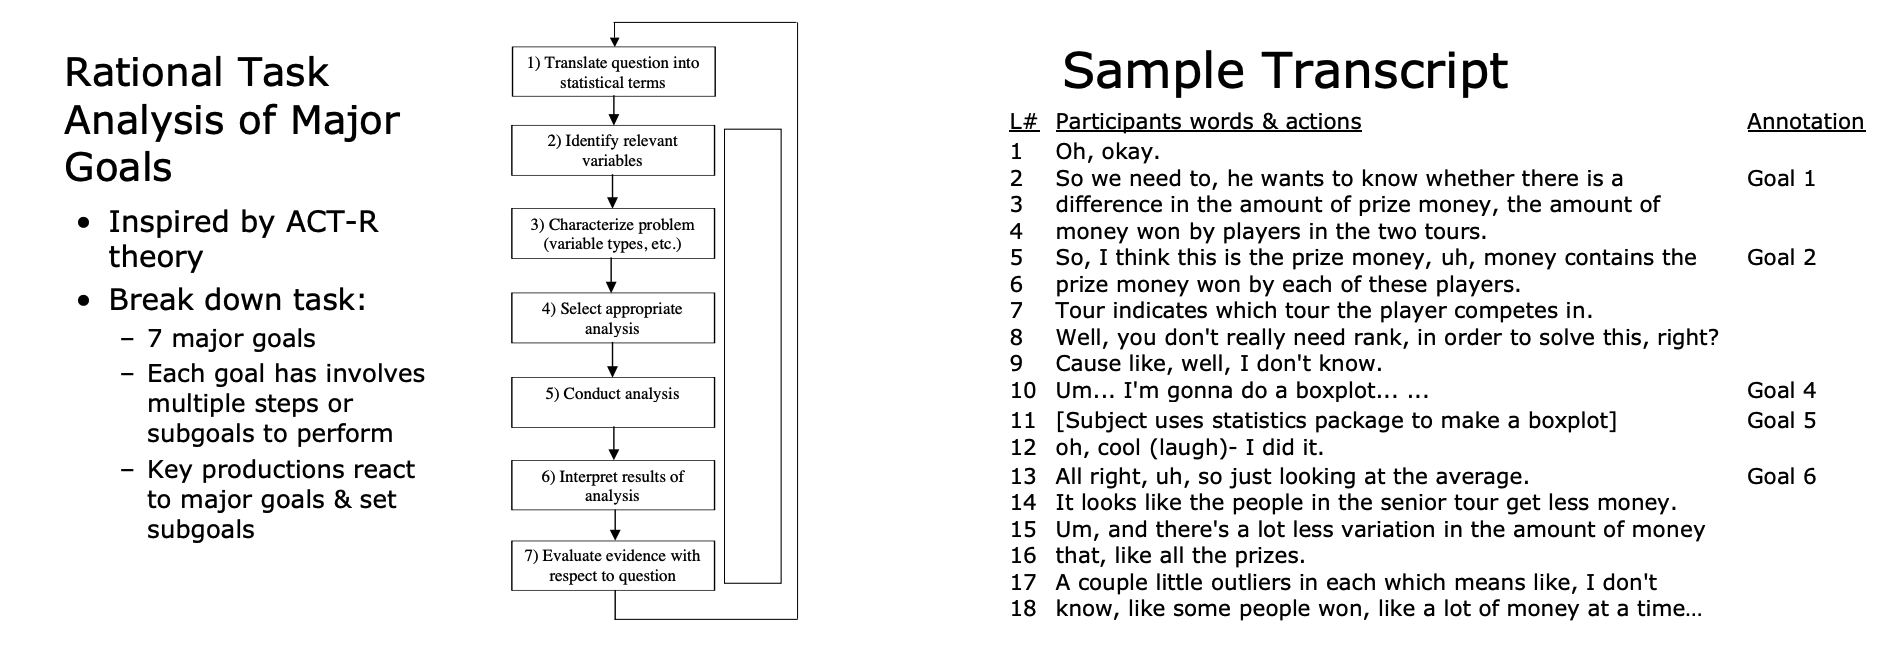

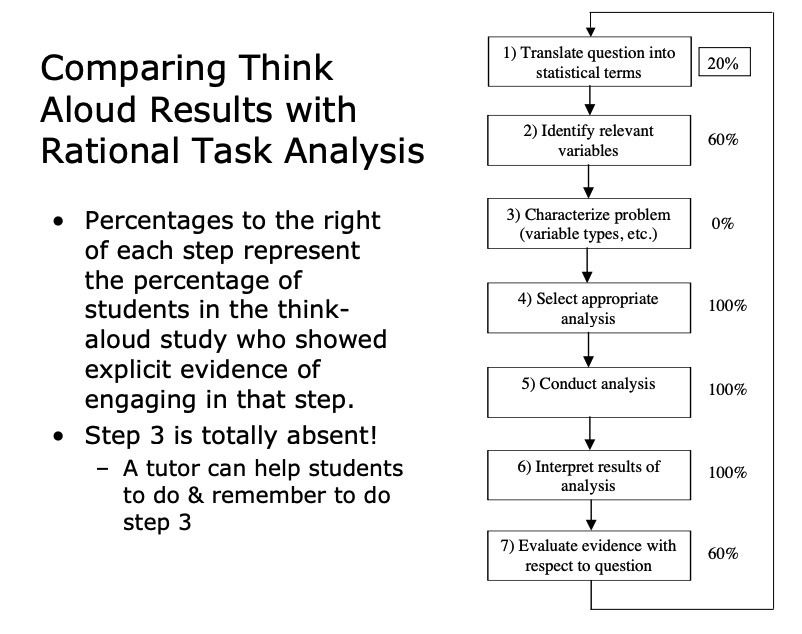

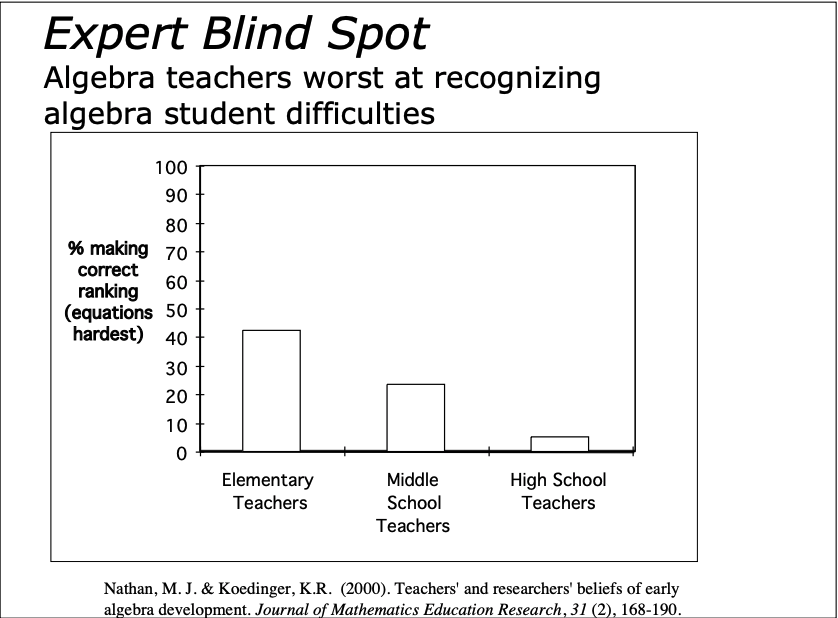

In [143]:
sw1 = ['python', 'scikit-learn']
sw2 = ['panda','numpy']
sw3 = ['Numpy', 'matplotlib']
sw4 = ['sklearn']
sw5 = ['keras', 'Tensorflow']

#["who", "what", "when", "where", "why", "how", "?"]
#["which", "won't", "can't", "isn't", "aren't", "is", "do", "does", "will", "can", "is"]

'''WHICH, AM, ARE, WAS, WERE, MAY, MIGHT, CAN, COULD, WILL, SHALL, WOULD, SHOULD, HAS, HAVE, HAD, and DID. Perhaps also IF to go with WHEN. Also consider IN, AT, TO, FROM, and ON, plus maybe UNDER and OVER.'''

# Importance of each stage
sww1 = 1
sww2 = 2
sww3 = 2
sww4 = 2
sww5 = 3

In [144]:
data['Stage 1'] = 0
data['Stage 2'] = 0
data['Stage 3'] = 0
data['Stage 4'] = 0
data['Stage 5'] = 0

data['Stage 1'] = data['Input'].apply(lambda x: len([x for x in str(x).replace(';',' ').replace(',', ' ').split(' ') if x in sw1]))
data['Stage 2'] = data['Input'].apply(lambda x: len([x for x in str(x).replace(';',' ').replace(',', ' ').split(' ') if x in sw2]))
data['Stage 3'] = data['Input'].apply(lambda x: len([x for x in str(x).replace(';',' ').replace(',', ' ').split(' ') if x in sw3]))
data['Stage 4'] = data['Input'].apply(lambda x: len([x for x in str(x).replace(';',' ').replace(',', ' ').split(' ') if x in sw4]))
data['Stage 5'] = data['Input'].apply(lambda x: len([x for x in str(x).replace(';',' ').replace(',', ' ').split(' ') if x in sw5]))

data['Stage 1 Score'] = data['Stage 1'] * sww1
data['Stage 2 Score'] = data['Stage 2'] * sww2
data['Stage 3 Score'] = data['Stage 3'] * sww3
data['Stage 4 Score'] = data['Stage 4'] * sww4
data['Stage 5 Score'] = data['Stage 5'] * sww5
data['Final Score'] = data['Stage 1 Score'] + data['Stage 2 Score'] + data['Stage 3 Score'] + data['Stage 4 Score'] + data['Stage 5 Score']

### Syntax Analysis

An alternate approach is by relying entirely on syntax analysis that will give us more information like sentence structures and make the above process more accurate.

In [ ]:

SBARQ (Situation, Background, Assessment, Recommendation, Question)

(SBARQ (WH+ (W+) ...)
       (SQ ...*
           (V+) ...*)
       (?))
       
The WH+ node (WHNP/WHADVP/WHADJP) contains the question stem (who/what/when/where/why/how) and the SQ holds the inverted phrase.

(SBARQ 
  (WHNP 
    (WP What)) 
  (SQ 
    (VBZ is) 
    (NP 
      (DT the) 
      (NN question)))
  (. ?))


Penn-II TreeBank or QuestionBank NLTK Parser

https://www.computing.dcu.ie/~jjudge/pubs/judge06acl.pdf

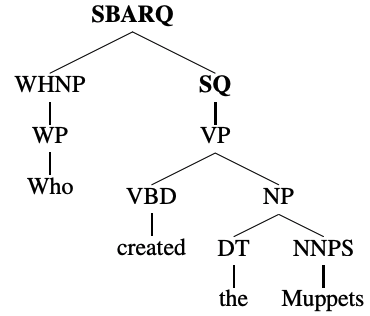

## Readibility Scores

### Scenario

Readibility scores give us a metric that is an estimation of how difficult or hard a particular set of text is to comprehend for people at different levels in school, college, and post college. Modified versions of these metrics are used by the DOD, US Air force to review and maintain consistency in verbal communication and technical manuals to increase quick comprehension and to avoid cognitive roadblocks. Several book publishers use these as a metric to assess the ideal audience/market segment for a particular book. 

At varsity, we can use this for sales conversations, instructor students sessions, and written student assessments and feedback. 

Each readibility metrics gives a particular score for a given text. a score of 6.4 means that a student in 6th grade should be able to read this text but would be hard for a student in 5th grade. 

In sales conversations, if the conversation is with a student, we migh want to avoid large deviations from the grade of the particular student If you are talking with a parent, The goal is not to check for the agreement between a parents age with the score of the conversation. We might want to avoid having conversations that is specific to 5th grade curriculum vocabulary. Eventhough a parent can theoretically understand 5th grade level conversations, they probably would not remember concepts in studied during 5th grade. 

Additionally, this also relates to the point mentioned about trying to relate a student's ability from one concept to another especially if we are trying to transfer qualities from abstract concepts like art to concrete concepts like math or Integral calculus to applied physics. 

Below is a study I mentioned about difficulty of story, word, vs equation based problem that is related to this. 

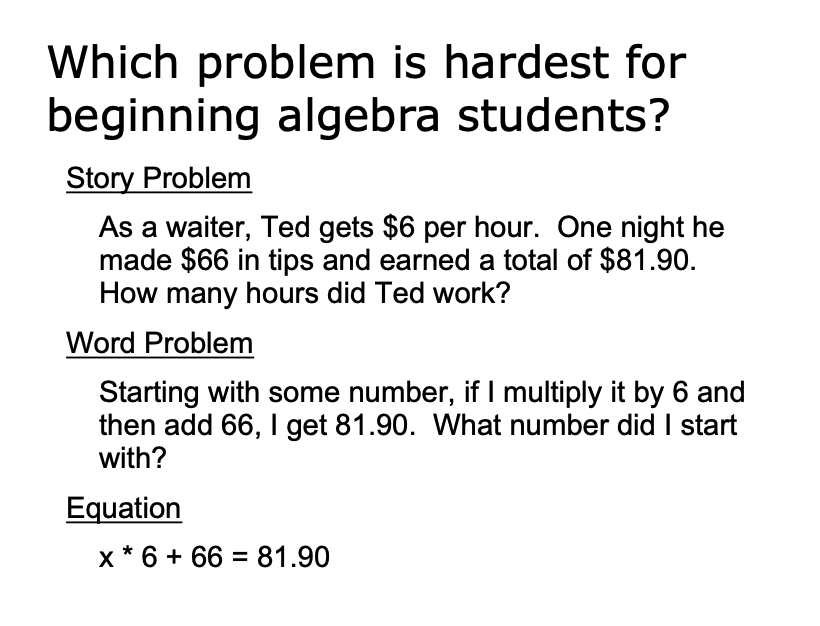 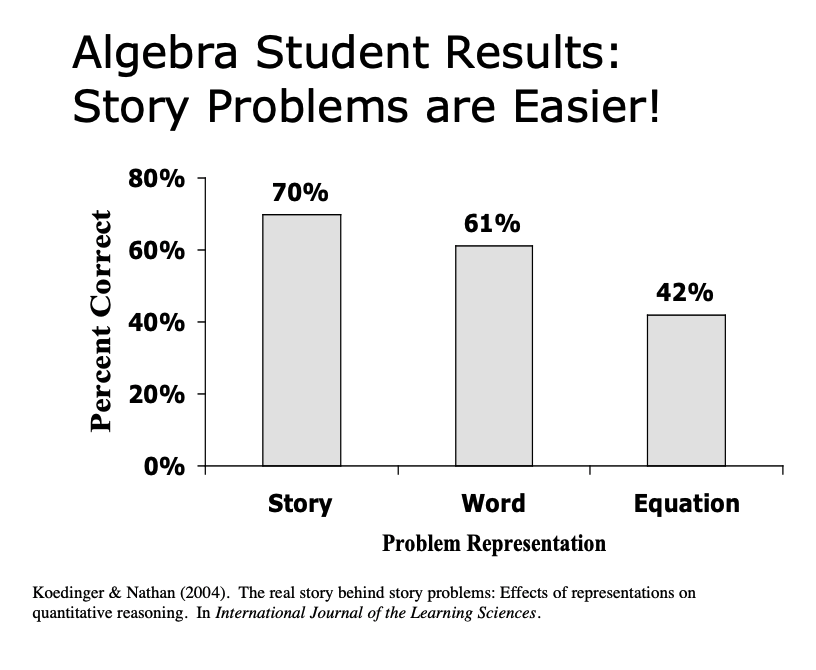

#### Movie Reviews Dataset

In [132]:
from nltk.corpus import movie_reviews
reviews = []
for fileid in movie_reviews.fileids():
    tag, filename = fileid.split("/")
    reviews.append((filename, tag, movie_reviews.raw(fileid)))
    
fdf = pd.DataFrame(reviews, columns = ['filename','tag','text'])

In [117]:
%matplotlib inline

from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

import textstat
from tqdm import tqdm
tqdm.pandas()
import numpy as np
from statistics import *

In [119]:
def plotability2v(a,b,title,bins=0.1,colors = ['#3A4750', '#F64E8B']):
    trace1 = ff.create_distplot([a,b],['Positive','Negative'], bin_size=bins, colors=colors, show_rug = False)
    trace1['layout'].update(title=title)
    iplot(trace1, filename="DistPlot")
    table_data= [["Statistical Measures","Sincere questions","Insincere questions"],
                ["Mean",mean(a),mean(b)],
                ["Standard Deviation",pstdev(a),pstdev(b)],
                ["Variance",pvariance(a),pvariance(b)],
                ["Median",median(a),median(b)],
                ["Maximum value",max(a),max(b)],
                ["Minimum value",min(a),min(b)]]
    trace2 = ff.create_table(table_data)
    iplot(trace2, filename='Table')

def plotability1v(a,title,bins=0.1,colors = ['#F64E8B']):
    trace1 = ff.create_distplot([a],['Single'], bin_size=bins, colors=colors, show_rug = False)
    trace1['layout'].update(title=title)
    iplot(trace1, filename="DistPlot")
    table_data= [["Statistical Measures","Sincere questions"],
                ["Mean",mean(a)],
                ["Standard Deviation",pstdev(a)],
                ["Variance",pvariance(a)],
                ["Median",median(a)],
                ["Maximum value",max(a)],
                ["Minimum value",min(a)]]
    trace2 = ff.create_table(table_data)
    iplot(trace2, filename='Table')   
    
# One function for all plots
def plot_readability(a,b,title,bins=0.1,colors=['#3A4750', '#F64E8B']):
    trace1 = ff.create_distplot([a,b], ["Sincere questions","Insincere questions"], bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures","Correct Answers","Incorrect Answers"],
                ["Mean",mean(a),mean(b)],
                ["Standard Deviation",pstdev(a),pstdev(b)],
                ["Variance",pvariance(a),pvariance(b)],
                ["Median",median(a),median(b)],
                ["Maximum value",max(a),max(b)],
                ["Minimum value",min(a),min(b)]]
    trace2 = ff.create_table(table_data)
    iplot(trace2, filename='Table')

### Each of these metrics can be trained on specific domains or a set of problems to give us more accurate results. The below models are baseline generalised public versions. 

### The Flesch Reading Ease formula

In [133]:
fdf['fre_pos_i'] = fdf['text'][fdf['tag']=='pos'].apply(lambda x: textstat.flesch_kincaid_grade(x))
fdf['fre_neg_i'] = fdf['text'][fdf['tag']=='neg'].apply(lambda x: textstat.flesch_kincaid_grade(x))
fdf['sent_count'] = fdf['text'].apply(lambda x: len([x for x in x.split('.')]))
fdf['fre_pos_i'] = fdf['fre_pos_i']/fdf['sent_count']
fdf['fre_neg_i'] = fdf['fre_neg_i']/fdf['sent_count']
fre_pos = fdf['fre_pos_i']
fre_neg = fdf['fre_neg_i']
fre_pos = [x for x in fre_pos if str(x) != 'nan']
fre_neg = [x for x in fre_neg if str(x) != 'nan']
plot_readability(fre_pos,fre_neg,"Flesch-Kincaid Reading Ease Grade Level", 0.5, colors=['#EE82EE','#0d98ba'])

### The Fog Scale (Gunning FOG Formula)

In [134]:
fdf['fre_pos_i'] = fdf['text'][fdf['tag']=='pos'].apply(lambda x: textstat.gunning_fog(x))
fdf['fre_neg_i'] = fdf['text'][fdf['tag']=='neg'].apply(lambda x: textstat.gunning_fog(x))
fdf['sent_count'] = fdf['text'].apply(lambda x: len([x for x in x.split('.')]))
fdf['fre_pos_i'] = fdf['fre_pos_i']/fdf['sent_count']
fdf['fre_neg_i'] = fdf['fre_neg_i']/fdf['sent_count']
fre_pos = fdf['fre_pos_i']
fre_neg = fdf['fre_neg_i']
fre_pos = [x for x in fre_pos if str(x) != 'nan']
fre_neg = [x for x in fre_neg if str(x) != 'nan']
plot_readability(fre_pos,fre_neg,"The Fog Scale (Gunning FOG Formula)", 0.5, colors=['#EE82EE','#0d98ba'])

### Automated Readibility Index

In [135]:
fdf['fre_pos_i'] = fdf['text'][fdf['tag']=='pos'].apply(lambda x: textstat.automated_readability_index(x))
fdf['fre_neg_i'] = fdf['text'][fdf['tag']=='neg'].apply(lambda x: textstat.automated_readability_index(x))
fdf['sent_count'] = fdf['text'].apply(lambda x: len([x for x in x.split('.')]))
fdf['fre_pos_i'] = fdf['fre_pos_i']/fdf['sent_count']
fdf['fre_neg_i'] = fdf['fre_neg_i']/fdf['sent_count']
fre_pos = fdf['fre_pos_i']
fre_neg = fdf['fre_neg_i']
fre_pos = [x for x in fre_pos if str(x) != 'nan']
fre_neg = [x for x in fre_neg if str(x) != 'nan']
plot_readability(fre_pos,fre_neg,"Automated Readibility Index", 0.5, colors=['#EE82EE','#0d98ba'])

### The Coleman-Liau Index

In [136]:
fdf['fre_pos_i'] = fdf['text'][fdf['tag']=='pos'].apply(lambda x: textstat.coleman_liau_index(x))
fdf['fre_neg_i'] = fdf['text'][fdf['tag']=='neg'].apply(lambda x: textstat.coleman_liau_index(x))
fdf['sent_count'] = fdf['text'].apply(lambda x: len([x for x in x.split('.')]))
fdf['fre_pos_i'] = fdf['fre_pos_i']/fdf['sent_count']
fdf['fre_neg_i'] = fdf['fre_neg_i']/fdf['sent_count']
fre_pos = fdf['fre_pos_i']
fre_neg = fdf['fre_neg_i']
fre_pos = [x for x in fre_pos if str(x) != 'nan']
fre_neg = [x for x in fre_neg if str(x) != 'nan']
plot_readability(fre_pos,fre_neg,"The Coleman-Liau Index", 0.5, colors=['#EE82EE','#0d98ba'])

### Linsear Write Formula

In [138]:
fdf['fre_pos_i'] = fdf['text'][fdf['tag']=='pos'].apply(lambda x: textstat.linsear_write_formula(x))
fdf['fre_neg_i'] = fdf['text'][fdf['tag']=='neg'].apply(lambda x: textstat.linsear_write_formula(x))
fdf['sent_count'] = fdf['text'].apply(lambda x: len([x for x in x.split('.')]))
fdf['fre_pos_i'] = fdf['fre_pos_i']/fdf['sent_count']
fdf['fre_neg_i'] = fdf['fre_neg_i']/fdf['sent_count']
fre_pos = fdf['fre_pos_i']
fre_neg = fdf['fre_neg_i']
fre_pos = [x for x in fre_pos if str(x) != 'nan']
fre_neg = [x for x in fre_neg if str(x) != 'nan']
plot_readability(fre_pos,fre_neg,"Linsear Write Formula", 0.5, colors=['#EE82EE','#0d98ba'])

### Dale-Chall Readability Score

In [139]:
fdf['fre_pos_i'] = fdf['text'][fdf['tag']=='pos'].apply(lambda x: textstat.dale_chall_readability_score(x))
fdf['fre_neg_i'] = fdf['text'][fdf['tag']=='neg'].apply(lambda x: textstat.dale_chall_readability_score(x))
fdf['sent_count'] = fdf['text'].apply(lambda x: len([x for x in x.split('.')]))
fdf['fre_pos_i'] = fdf['fre_pos_i']/fdf['sent_count']
fdf['fre_neg_i'] = fdf['fre_neg_i']/fdf['sent_count']
fre_pos = fdf['fre_pos_i']
fre_neg = fdf['fre_neg_i']
fre_pos = [x for x in fre_pos if str(x) != 'nan']
fre_neg = [x for x in fre_neg if str(x) != 'nan']
plot_readability(fre_pos,fre_neg,"Dale-Chall Readability Score", 0.5, colors=['#EE82EE','#0d98ba'])

### All Consensus

In [141]:
def consensus_all(text):
    return textstat.text_standard(text,float_output=True)

fdf['fre_pos_i'] = fdf['text'][fdf['tag']=='pos'].apply(lambda x: consensus_all(x))
fdf['fre_neg_i'] = fdf['text'][fdf['tag']=='neg'].apply(lambda x: consensus_all(x))
fdf['sent_count'] = fdf['text'].apply(lambda x: len([x for x in x.split('.')]))
fdf['fre_pos_i'] = fdf['fre_pos_i']/fdf['sent_count']
fdf['fre_neg_i'] = fdf['fre_neg_i']/fdf['sent_count']
fre_pos = fdf['fre_pos_i']
fre_neg = fdf['fre_neg_i']
fre_pos = [x for x in fre_pos if str(x) != 'nan']
fre_neg = [x for x in fre_neg if str(x) != 'nan']
plot_readability(fre_pos,fre_neg,"All Consensus", 0.5, colors=['#EE82EE','#0d98ba'])

# Sales Analysis - CTA/ Topic Modelling/ Categorical

### <b>Priming</b>

Priming is a phenomenon when a stimulus prior to an event changes the participants behavior during the event. 

General Example: Undergrads Lavish Spending after watching looking at photos of other students buying expensive clothes etc. 
Varsity Specific Example:- As given in the LDA example above, by personalizing the Varsity website to problem topics in each state, say in california we promote the sense of starting a tutoring session any place anytime since timing is a bigh issue, whereas in nebraska we focus on affordability and ROI.

Eduardo Porter, “How Money Affects Morality,” New York Times (January 3, 2013), http://economix.blogs.nytimes.com/2013/06/13/how-money- affects-morality/, accessed February 23, 2015.

Example:- French and German Wine and Music in Restaurant

Adrian C. North, David J. Hargreaves, and Jennifer McKendrick, “The Influence of In-Store Music on Wine Selections,” Journal of Applied Psychology 84, no. 2 (1999): 271–276.

### <b>Nudging</b>

General Example:- Default Organ Donors are less likely to leave the organ donor program vs asking non-donors to Opt-In

https://sparq.stanford.edu/solutions/opt-out-policies-increase-organ-donation

Davidai, S., Gilovich, T., & Ross, L. (2012). The meaning of default options for potential organ donors. Proceedings of the National Academy of Sciences, 15201-15205.

### <b>Covariance</b>

General Example:- Expectation that if the car's exterior is clean, then the interior is clean as well, including the motor parts.
Varsity Specific Example:- Design of website and quality of reviews posted on reviews would improve trust and preception of services provided.
Michael R. Solomon, Sarah Drenan, and Chester A. Insko, “Popular Induction: When Is Consensus Information Informative?” Journal of Personality 49, no. 2 (1981): 212–224.

Howard Beales, Michael B. Mazis, Steven C. Salop and Richard Staelin, “Consumer Search and Public Policy,” Journal of Consumer Research 8, no. 1 (June 1981): 11–22.


### <b>Family - Collective Decision Making</b>

Varsity Specific Example:- By personalizing emails/ brochures/ sales calls based on age of student and role of the person calling varsity to know about the service as stated below.

<b>Different Roles</b>
1. <b>Initiator</b> — The person who brings up the idea or identifies a need.
2. <b>Gatekeeper</b> — The person who conducts the information search and controls the flow of information available to the group. In organizational contexts, the gatekeeper identifies possible vendors and products for the rest of the group to consider.
3. <b>Influencer </b>— The person who tries to sway the outcome of the decision. Some people may be more motivated than others to get involved, and participants also possess different amounts of power to get their point across.
4. <b>Buyer </b>— The person who actually makes the purchase. The buyer may or may not actually use the product.
5. <b>User</b> — The person who actually consumes the product or service.

<b>Different Types of decisions in a family:-</b>

<b>1. Consensual Purchase Decision</b>

Example: - Buying a Dog and splitting up the responsibilities amobg family members

<b>2. Accomodative Purchase Decision</b>

Example: - TV Subscription
Involves bargaining, coercion, and compromise


Harry L. Davis, “Decision-Making Within the Household,” Journal of Con- sumer Research 2 (March 1972): 241–260; Michael B. Menasco and David J. Curry, “Utility and Choice: An Empirical Study of Wife/Husband Decision- Making,” Journal of Consumer Research 16 (June 1989): 87–97; Conway Lackman and John M. Lanasa, “Family Decision-Making Theory: An Overview and Assessment,” Psychology & Marketing 10 (March–April 1993): 81–94.

Shannon Dortch, “Money and Marital Discord,” American Demographics (October 1994): 11.

### Loss Aversion

General Example:- Teacher's paid an extra bonus at the start of the year to improve a student's progress but were told that if the student's performance does not increase the bonus would be deducted from salaries at the end of the year are more dedicated to improving the student's learning compared to teachers who were promised bonus only at the end of the year. 

Varsity Specific Example:- Increase Tutor motivation through incentives prior to an assignment vs at the end. 

https://www.npr.org/sections/health-shots/2012/09/18/161159263/teachers-expectations-can-influence-how-students-perform
